# Initial Set Up

## Importing libraries

In [14]:
import matplotlib.pyplot as plt

from keras import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD, Adadelta
 
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from modules.helpers import load_data

import mlflow
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow_experiment_id = 173184969061571471
mlflow.autolog(disable=True)

In [15]:
(train_x, train_y), (val_x, val_y), (test_x, test_y) = load_data('dnn')

# Hyper Parameter Tuning

In [16]:
run = False

We apply early stopping to prevent overfitting.

In [17]:
early_stopping = EarlyStopping(monitor='val_loss',
                               mode='min',
                               verbose=1,
                               patience=3)

In [18]:
def create_model(activation='relu',
                 dropout_rate=0.2, 
                 optimizer=Adam,
                 learning_rate=0.01):
    model = Sequential([
        Dense(64, activation=activation, input_shape=(51,)),
        Dropout(dropout_rate),  
        Dense(64, activation=activation),  
        Dropout(dropout_rate),  
        Dense(32, activation=activation),  
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid') 
    ])
    opt = optimizer(learning_rate=learning_rate)
    
    model.compile(
        optimizer=opt,  
        loss='binary_crossentropy',  
        metrics=['accuracy']  
    )
    
    return model

In [19]:
param_grid = {
    'activation': ['relu', 'softplus', 'sigmoid', 'tanh'],
    'dropout_rate': [0.1, 0.2, 0.3],
    'optimizer': [Adam, SGD, Adadelta],  
    'learning_rate': [0.005, 0.01]  
}

param_configs = [
    {
        'activation': activation,
        'dropout_rate': dropout_rate,
        'optimizer': optimizer,
        'learning_rate': learning_rate,
    }
    for activation in param_grid['activation']
    for dropout_rate in param_grid['dropout_rate']
    for optimizer in param_grid['optimizer']
    for learning_rate in param_grid['learning_rate']
]

In [20]:
if run == True:
    for i in range(len(param_configs)):   
        param_config = param_configs[i]
        with mlflow.start_run(experiment_id=mlflow_experiment_id):
            for param, value in param_config.items():
                mlflow.log_param(param, value)
            
            model = create_model(**param_config)

            history = model.fit(train_x,
                    train_y,
                    epochs=15,
                    batch_size=50,
                    validation_data=(val_x, val_y))
            
            mlflow.log_metric("Accuracy", history.history['val_accuracy'][-1])
            mlflow.log_metric("Loss", history.history['val_loss'][-1])
            
            # Log Model
            mlflow.sklearn.log_model(
                sk_model=model,
                artifact_path=f'dnn-{i}',
                registered_model_name=f'dnn-{i}'
                )
            
            del model, history
else:
    print("No new runs added")

No new runs added


# Final Model

In [21]:
model = create_model(activation='sigmoid',
                     dropout_rate=0.3,
                     optimizer=Adam,
                     learning_rate=0.005)

model.fit(train_x,
          train_y,
          epochs=15,
          batch_size=50,
          validation_data=(val_x, val_y))

Epoch 1/15
905/905 [==============================] - 5s 5ms/step - loss: 0.5477 - accuracy: 0.7237 - val_loss: 0.5204 - val_accuracy: 0.7472
Epoch 2/15
905/905 [==============================] - 5s 5ms/step - loss: 0.5273 - accuracy: 0.7408 - val_loss: 0.5179 - val_accuracy: 0.7491
Epoch 3/15
905/905 [==============================] - 5s 6ms/step - loss: 0.5249 - accuracy: 0.7407 - val_loss: 0.5136 - val_accuracy: 0.7479
Epoch 4/15
905/905 [==============================] - 5s 6ms/step - loss: 0.5236 - accuracy: 0.7412 - val_loss: 0.5137 - val_accuracy: 0.7485
Epoch 5/15
905/905 [==============================] - 4s 5ms/step - loss: 0.5220 - accuracy: 0.7421 - val_loss: 0.5119 - val_accuracy: 0.7493
Epoch 6/15
905/905 [==============================] - 5s 5ms/step - loss: 0.5214 - accuracy: 0.7427 - val_loss: 0.5149 - val_accuracy: 0.7466
Epoch 7/15
905/905 [==============================] - 4s 4ms/step - loss: 0.5208 - accuracy: 0.7429 - val_loss: 0.5144 - val_accuracy: 0.7502
Epoch 

354/354 [==============================] - 0s 660us/step


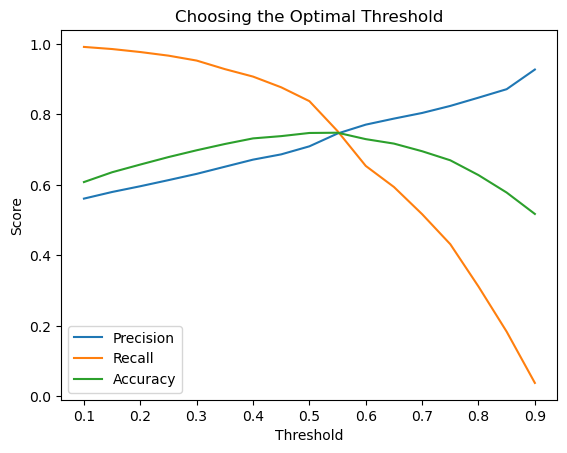

- Threshold: 0.35 | Accuracy: 0.716 | Precision: 0.652 | Recall: 0.929
- Threshold: 0.40 | Accuracy: 0.732 | Precision: 0.672 | Recall: 0.907
- Threshold: 0.45 | Accuracy: 0.738 | Precision: 0.687 | Recall: 0.877
- Threshold: 0.50 | Accuracy: 0.747 | Precision: 0.710 | Recall: 0.838
- Threshold: 0.55 | Accuracy: 0.748 | Precision: 0.746 | Recall: 0.753
- Threshold: 0.60 | Accuracy: 0.730 | Precision: 0.771 | Recall: 0.654
- Threshold: 0.65 | Accuracy: 0.717 | Precision: 0.788 | Recall: 0.594


In [22]:
# list of possible threshold values
threshold_values = [i / 100 for i in range(10,95,5)]

# list to hold precision, recall, accuracy scores for each possible threshold value
prec_scores = []
rec_scores = []
acc_scores = []

for threshold in threshold_values:
    y_pred = (model.predict(val_x) > threshold).astype(int)
    prec_scores.append(precision_score(val_y, y_pred))
    rec_scores.append(recall_score(val_y, y_pred))
    acc_scores.append(accuracy_score(val_y, y_pred))
    
plt.plot(threshold_values, prec_scores, label='Precision')
plt.plot(threshold_values, rec_scores, label='Recall')
plt.plot(threshold_values, acc_scores, label='Accuracy')
plt.title('Choosing the Optimal Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.show()

for i in range(len(threshold_values)):
     if acc_scores[i] > 0.7:
         print(f'- Threshold: {threshold_values[i]:.2f} | Accuracy: {acc_scores[i]:.3f} | Precision: {prec_scores[i]:.3f} | Recall: {rec_scores[i]:.3f}')

optimal_threshold = 0.45

## Model Evaluation

In [23]:
test_loss, test_acc = model.evaluate(test_x, test_y)
print("Testing loss:", test_loss)
print("Testing accuracy:", test_acc)

442/442 [==============================] - 1s 2ms/step - loss: 0.5078 - accuracy: 0.7501
Testing loss: 0.5078132152557373
Testing accuracy: 0.7501237988471985


In [24]:
y_pred = (model.predict(test_x) > optimal_threshold).astype(int)

442/442 [==============================] - 0s 765us/step


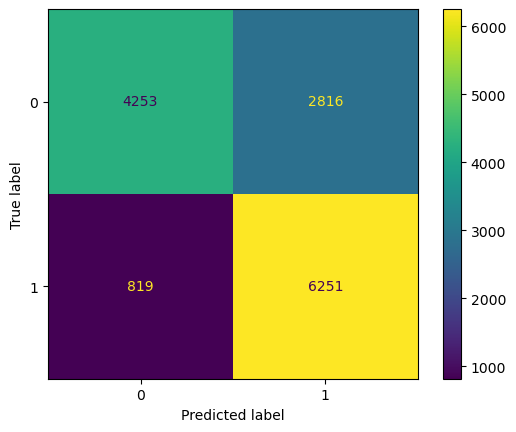

In [28]:
cm = confusion_matrix(test_y, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

In [29]:
print("Classification Report:")
print(classification_report(test_y, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.60      0.70      7069
           1       0.69      0.88      0.77      7070

    accuracy                           0.74     14139
   macro avg       0.76      0.74      0.74     14139
weighted avg       0.76      0.74      0.74     14139

